In [12]:
# === GOLD schema → DataFrame variables (cvss_v3, dim_cve, mv_cve_all_cvss, ...) ===
import os, re
import psycopg2
import pandas as pd
from types import SimpleNamespace

DB_CONFIG = {
    "user": os.getenv("PG_USER", "postgres"),
    "password": os.getenv("PG_PASSWORD", "tip_pwd"),
    "host": os.getenv("PG_HOST", "localhost"),
    "port": os.getenv("PG_PORT", "5432"),
    "database": os.getenv("PG_DB", "tip"),
}
SCHEMA = "gold"

def connect_db():
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        print("✓ DB connected")
        return conn
    except Exception as e:
        raise RuntimeError(f"DB connection failed: {e}")

def list_gold_relations(conn):
    q = """
    WITH base_views AS (
        SELECT table_name AS name, table_type AS kind
        FROM information_schema.tables
        WHERE table_schema = %s AND table_type IN ('BASE TABLE','VIEW')
    ),
    matviews AS (
        SELECT matviewname AS name, 'MATERIALIZED VIEW'::text AS kind
        FROM pg_matviews
        WHERE schemaname = %s
    )
    SELECT name, kind
    FROM base_views
    UNION ALL
    SELECT name, kind
    FROM matviews
    ORDER BY name;
    """
    return pd.read_sql_query(q, conn, params=[SCHEMA, SCHEMA])

def _to_valid_identifier(name: str) -> str:
    """Turn relation name into a safe Python identifier (for attribute/variable)."""
    ident = re.sub(r'\W+', '_', name)  # non-word → _
    ident = re.sub(r'^(\d)', r'_\1', ident)  # no leading digit
    return ident.lower()

def load_gold_as_namespace(conn, limit=None, verbose=True):
    """
    Loads every relation from `gold` into a SimpleNamespace with attributes named
    after the relation (safe identifiers). Also returns a {attr_name: relation_name} map.
    """
    rels = list_gold_relations(conn)
    if rels.empty:
        print("⚠️ No relations found in schema 'gold'")
        return SimpleNamespace(), {}

    ns = SimpleNamespace()
    name_map = {}  # attr_name -> real relation name
    used = set()

    for _, row in rels.iterrows():
        rel_name = row["name"]
        kind = row["kind"]
        fq = f'{SCHEMA}."{rel_name}"'
        sql = f"SELECT * FROM {fq}" + (f" LIMIT {int(limit)}" if limit else "")
        try:
            df = pd.read_sql_query(sql, conn)
        except Exception as e:
            print(f"✗ Load error {rel_name} ({kind}): {e}")
            continue

        # choose a variable/attribute name
        base = _to_valid_identifier(rel_name)
        cand = base
        i = 1
        while cand in used:
            i += 1
            cand = f"{base}_{i}"
        setattr(ns, cand, df)
        name_map[cand] = rel_name
        used.add(cand)

        if verbose:
            print(f"✓ {cand:<22} ← {rel_name:<22} [{kind:<18}] rows={len(df)} cols={len(df.columns)}")

    return ns, name_map

def inject_into_globals(ns, g=None):
    """Convenience: inject namespace DataFrames as top-level variables (Jupyter)."""
    g = g if g is not None else globals()
    for k, v in ns.__dict__.items():
        g[k] = v
    print(f"✓ Injected {len(ns.__dict__)} datasets into globals()")

# --- Run this cell to load & expose variables like cvss_v3, dim_cve, mv_cve_all_cvss ---
conn = connect_db()
ns, name_map = load_gold_as_namespace(conn, limit=None, verbose=True)
inject_into_globals(ns)   # now you can call cvss_v3.head(), dim_cve.head(), etc.
conn.close()

# Optional: show mapping if any names were adjusted
pd.DataFrame([{"python_var": k, "relation": v} for k, v in name_map.items()])


✓ DB connected
✓ bridge_cve_products    ← bridge_cve_products    [BASE TABLE        ] rows=75914 cols=4
✓ cvss_v2                ← cvss_v2                [BASE TABLE        ] rows=23237 cols=15
✓ cvss_v3                ← cvss_v3                [BASE TABLE        ] rows=20173 cols=18
✓ cvss_v4                ← cvss_v4                [BASE TABLE        ] rows=4501 cols=16
✓ dim_cve                ← dim_cve                [BASE TABLE        ] rows=36359 cols=12
✓ dim_cvss_source        ← dim_cvss_source        [BASE TABLE        ] rows=246 cols=3
✓ dim_products           ← dim_products           [BASE TABLE        ] rows=16707 cols=9
✓ gold_cve_summary       ← gold_cve_summary       [BASE TABLE        ] rows=3150 cols=18
✓ gold_cvss_version_comparison ← gold_cvss_version_comparison [BASE TABLE        ] rows=3150 cols=11
✓ gold_product_risk_profile ← gold_product_risk_profile [BASE TABLE        ] rows=1805 cols=18
✓ gold_vendor_security_metrics ← gold_vendor_security_metrics [BASE TABLE   

,python_var,relation
0,bridge_cve_products,bridge_cve_products
1,cvss_v2,cvss_v2
2,cvss_v3,cvss_v3
3,cvss_v4,cvss_v4
4,dim_cve,dim_cve
5,dim_cvss_source,dim_cvss_source
6,dim_products,dim_products
7,gold_cve_summary,gold_cve_summary
8,gold_cvss_version_comparison,gold_cvss_version_comparison
9,gold_product_risk_profile,gold_product_risk_profile


In [22]:
dim_cve.head()

,cve_id,title,description,category,published_date,last_modified,loaded_at,cve_year,remotely_exploit,source_identifier,created_at,updated_at
0,CVE-2010-0001,gzip Integer Underflow RCE,The following products are affected byCVE-2010...,undefined,2010-01-29 18:30:00,2025-04-11 00:51:00,2025-10-16 16:45:20.576894,2010,None,secalert@redhat.com,2025-10-17 10:56:41.092685,2025-10-17 10:56:41.092685
1,CVE-2010-0002,Mandriva Bash Command Injection Vulnerability,The following products are affected byCVE-2010...,undefined,2010-01-14 18:30:00,2025-04-09 00:30:00,2025-10-16 19:42:06.875601,2010,False,secalert@redhat.com,2025-10-17 10:56:41.092685,2025-10-17 10:56:41.092685
2,CVE-2010-0003,Linux kernel Information Disclosure and Denial...,The following products are affected byCVE-2010...,undefined,2010-01-26 18:30:00,2025-04-11 00:51:00,2025-10-16 16:44:24.032765,2010,False,secalert@redhat.com,2025-10-17 10:56:41.092685,2025-10-17 10:56:41.092685
3,CVE-2010-0004,ViewVC Information Disclosure Vulnerability,The following products are affected byCVE-2010...,undefined,2010-01-29 18:30:00,2025-04-11 00:51:00,2025-10-16 16:45:20.576894,2010,None,secalert@redhat.com,2025-10-17 10:56:41.092685,2025-10-17 10:56:41.092685
4,CVE-2010-0005,ViewVC Unauthenticated Access Restriction Bypa...,The following products are affected byCVE-2010...,undefined,2010-01-29 18:30:00,2025-04-11 00:51:00,2025-10-16 16:45:20.576894,2010,None,secalert@redhat.com,2025-10-17 10:56:41.092685,2025-10-17 10:56:41.092685


In [16]:

mv_top_critical_cves['title'].to_csv('my_column.csv', index=False)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hamza\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hamza\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


1. BASIC DATA OVERVIEW
Total vulnerabilities: 30
Average title length: 61.13 characters

2. VENDOR ANALYSIS
          Vendor  Count
1      Microsoft      4
4            IBM      4
0         Oracle      3
2          Apple      3
3          Cisco      3
7         Google      3
6        Mozilla      2
5             HP      1
9       Symantec      1
10        Novell      1
8            Sun      0
11  RealNetworks      0
12         Opera      0
13      GIGABYTE      0

3. VULNERABILITY TYPE ANALYSIS
                     Type  Count
1   Remote Code Execution     10
0         Buffer Overflow      5
2       Denial of Service      3
3   Authentication Bypass      2
5       Memory Corruption      2
4          Code Injection      1
6     Directory Traversal      1
7        Default Password      0
8  Information Disclosure      0
9    Privilege Escalation      0

4. TOP KEYWORDS (excluding stopwords)

Top 15 keywords:
  vulnerability: 22
  code: 11
  execution: 11
  remote: 7
  buffer: 5
  overflo

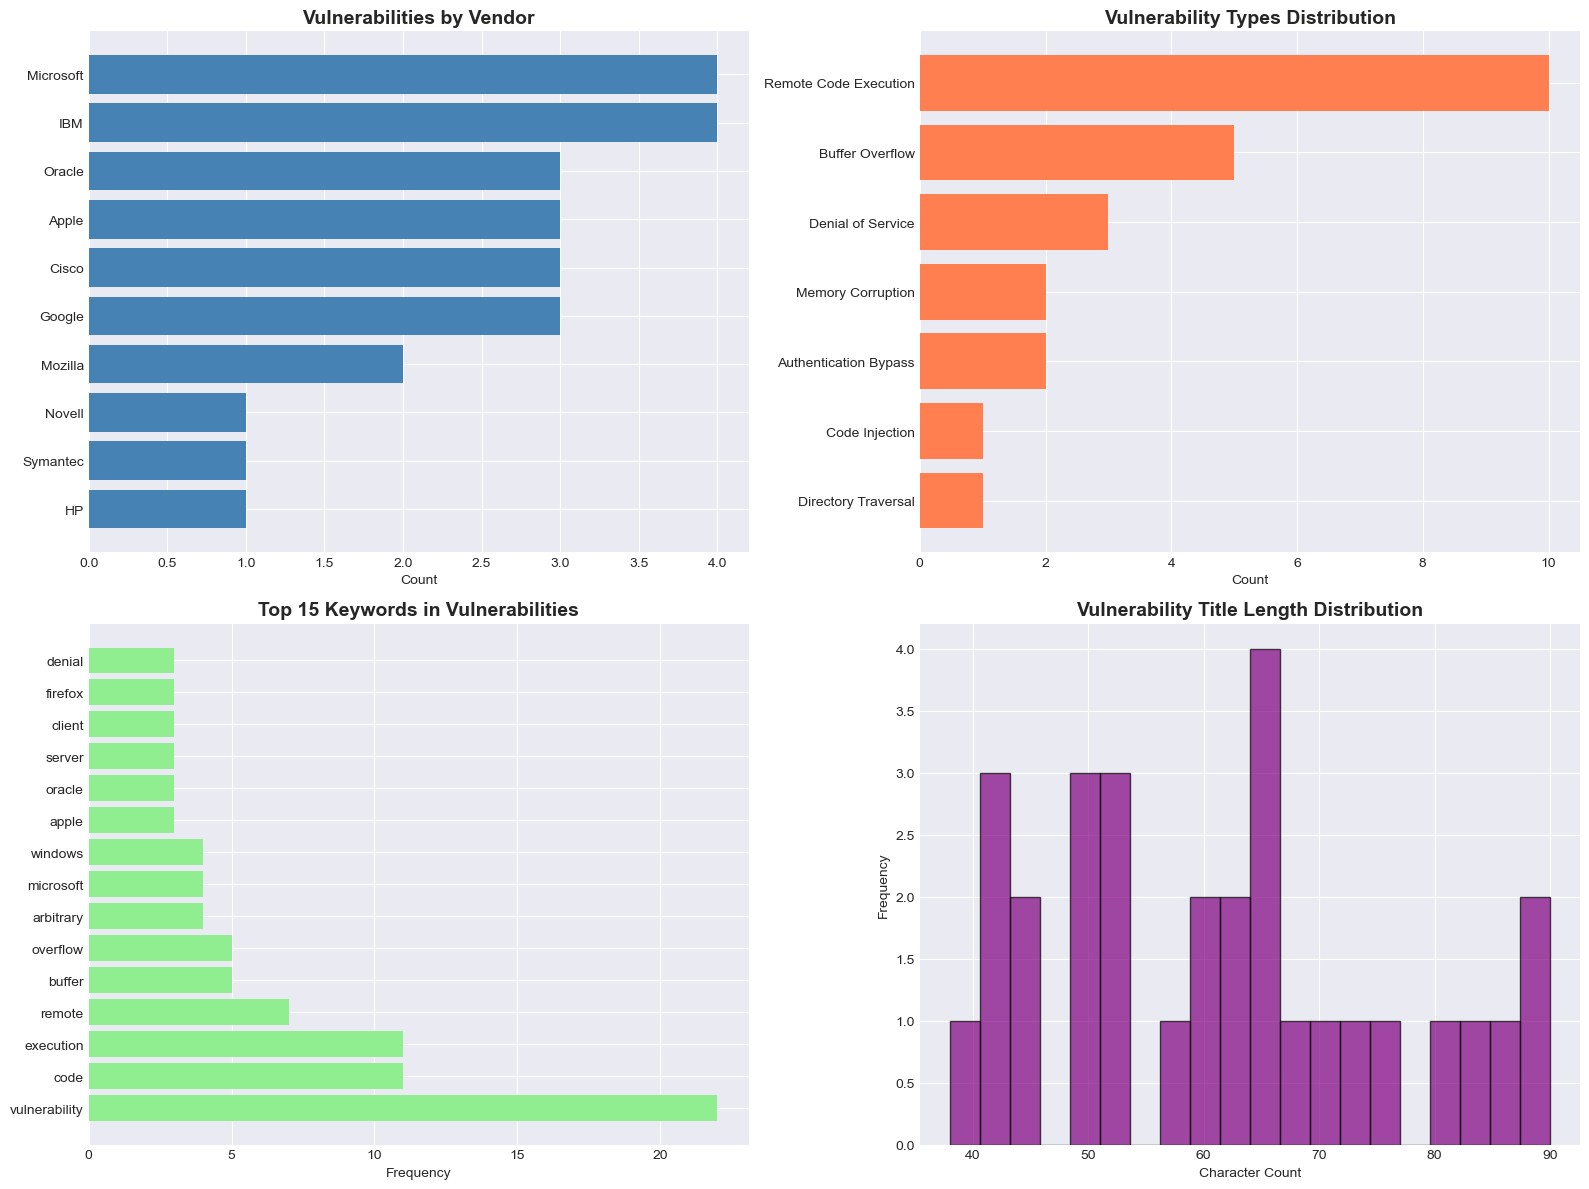


5. GENERATING WORD CLOUD
✓ Word cloud saved as 'vulnerability_wordcloud.png'


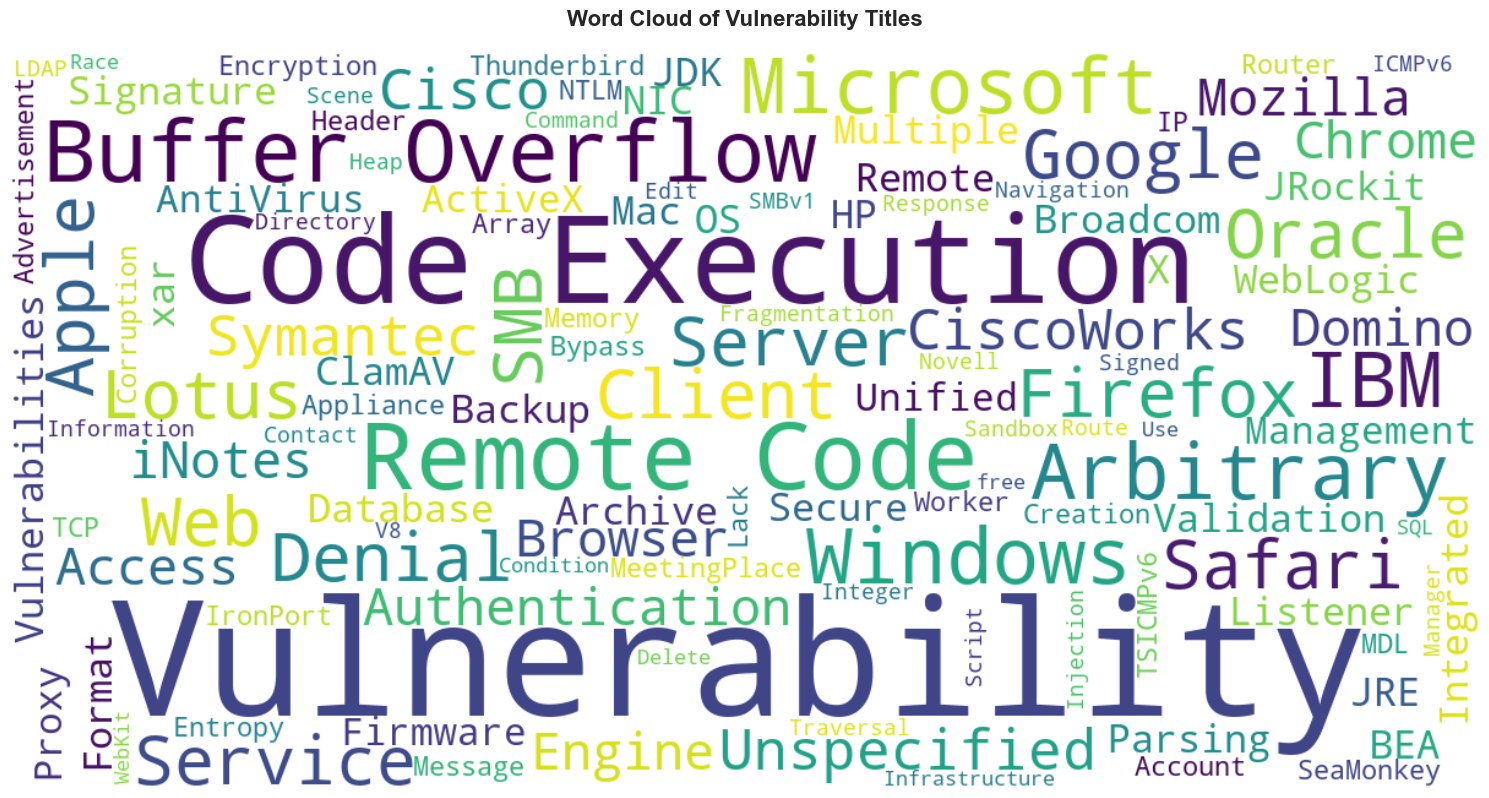


6. SUMMARY INSIGHTS
📊 Top Vendor: Microsoft (4 vulnerabilities)
🔴 Most Common Vulnerability Type: Remote Code Execution (10 cases)
📝 Average Title Length: 61 characters
🔤 Unique Keywords: 99
⚠️  Total Vulnerabilities Analyzed: 30


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Sample vulnerability data
vulnerabilities = [
    "Apple Mac OS X xar Signature Validation Vulnerability",
    "Oracle Database Listener Unspecified Remote Vulnerability",
    "Oracle Secure Backup Buffer Overflow Vulnerability",
    "Oracle WebLogic Server Remote Code Execution",
    "BEA JRockit JRE/JDK Multiple Vulnerabilities",
    "ClamAV Archive Format Parsing Vulnerability",
    "HP Broadcom Integrated NIC Management Firmware Arbitrary Code Execution Vulnerability",
    "Symantec Client Proxy Symantec AntiVirus ActiveX Buffer Overflow",
    "CiscoWorks CiscoWorks Buffer Overflow Vulnerability",
    "Cisco Unified MeetingPlace Web Server Authentication Bypass and Account Creation",
    "Cisco IronPort Encryption Appliance Remote Code Execution Vulnerability",
    "Mozilla Firefox Browser Engine Denial of Service and Remote Code Execution Vulnerability",
    "Firefox Web Worker Array Message Denial of Service",
    "Mozilla Firefox/Thunderbird/SeaMonkey Browser Engine Memory Corruption Vulnerability",
    "Microsoft SMB NTLM Authentication Lack of Entropy Vulnerability",
    "Windows TSICMPv6 Router Advertisement Code Execution Vulnerability",
    "Windows TCP/IP Header MDL Fragmentation Vulnerability",
    "Microsoft Windows ICMPv6 Route Information Buffer Overflow Vulnerability",
    "Microsoft SMB Client SMBv1/2 Response Arbitrary Code Execution Vulnerability",
    "Microsoft Windows SMB Client Arbitrary Code Execution Vulnerability",
    "IBM Lotus iNotes Unspecified Edit Contact Scene Vulnerability",
    "IBM Domino Web Access Script Command Injection Vulnerability",
    "IBM Lotus iNotes Navigation Vulnerability",
    "Novell Access Manager Directory Traversal Remote Code Execution",
    "IBM Lotus Domino LDAP Server Heap Buffer Overflow",
    "Google V8 Signed Integer Vulnerability (Arbitrary Code Execution)",
    "Google Chrome Sandbox Infrastructure Race Condition Vulnerability",
    "Google Chrome SQL Delete Vulnerability",
    "Apple Safari WebKit Use-after-free Vulnerability (Remote Code Execution/Denial of Service)",
    "Apple Safari Safari Remote Code Execution"
]

# Create DataFrame
df = pd.DataFrame({'title': vulnerabilities})

# ============== DATA CLEANING & PREPROCESSING ==============
print("=" * 80)
print("1. BASIC DATA OVERVIEW")
print("=" * 80)
print(f"Total vulnerabilities: {len(df)}")
print(f"Average title length: {df['title'].str.len().mean():.2f} characters\n")

# ============== VENDOR EXTRACTION ==============
print("=" * 80)
print("2. VENDOR ANALYSIS")
print("=" * 80)

vendors = ['Oracle', 'Microsoft', 'Apple', 'Cisco', 'IBM', 'HP', 'Mozilla', 'Google', 'Sun', 'Symantec', 'Novell', 'RealNetworks', 'Opera', 'GIGABYTE']
vendor_counts = {}

for vendor in vendors:
    count = df['title'].str.contains(vendor, case=False).sum()
    vendor_counts[vendor] = count

vendor_df = pd.DataFrame(list(vendor_counts.items()), columns=['Vendor', 'Count']).sort_values('Count', ascending=False)
print(vendor_df)

# ============== VULNERABILITY TYPE EXTRACTION ==============
print("\n" + "=" * 80)
print("3. VULNERABILITY TYPE ANALYSIS")
print("=" * 80)

vuln_types = {
    'Buffer Overflow': r'buffer overflow|stack.?based buffer overflow',
    'Remote Code Execution': r'remote code execution|arbitrary code execution',
    'Denial of Service': r'denial of service|dos',
    'Authentication Bypass': r'authentication bypass|authentication',
    'Code Injection': r'injection|command injection|script injection',
    'Memory Corruption': r'memory corruption|use.?after.?free|out.?of.?bounds',
    'Directory Traversal': r'directory traversal|path traversal',
    'Default Password': r'default password',
    'Information Disclosure': r'information disclosure|data disclosure',
    'Privilege Escalation': r'privilege escalation|escalation'
}

type_counts = {}
for vuln_type, pattern in vuln_types.items():
    count = df['title'].str.contains(pattern, case=False, regex=True).sum()
    type_counts[vuln_type] = count

type_df = pd.DataFrame(list(type_counts.items()), columns=['Type', 'Count']).sort_values('Count', ascending=False)
print(type_df)

# ============== WORD FREQUENCY ANALYSIS ==============
print("\n" + "=" * 80)
print("4. TOP KEYWORDS (excluding stopwords)")
print("=" * 80)

stop_words = set(stopwords.words('english'))
all_words = []

for title in df['title']:
    words = re.findall(r'\b[a-z]+\b', title.lower())
    filtered_words = [w for w in words if w not in stop_words and len(w) > 3]
    all_words.extend(filtered_words)

word_freq = Counter(all_words).most_common(15)
print("\nTop 15 keywords:")
for word, freq in word_freq:
    print(f"  {word}: {freq}")

# ============== VISUALIZATIONS ==============
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Vendors
vendor_plot_df = vendor_df[vendor_df['Count'] > 0].sort_values('Count')
axes[0, 0].barh(vendor_plot_df['Vendor'], vendor_plot_df['Count'], color='steelblue')
axes[0, 0].set_title('Vulnerabilities by Vendor', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Count')

# Plot 2: Vulnerability Types
type_plot_df = type_df[type_df['Count'] > 0].sort_values('Count')
axes[0, 1].barh(type_plot_df['Type'], type_plot_df['Count'], color='coral')
axes[0, 1].set_title('Vulnerability Types Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Count')

# Plot 3: Top Keywords
words_list = [w[0] for w in word_freq]
counts_list = [w[1] for w in word_freq]
axes[1, 0].barh(words_list, counts_list, color='lightgreen')
axes[1, 0].set_title('Top 15 Keywords in Vulnerabilities', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Frequency')

# Plot 4: Title Length Distribution
axes[1, 1].hist(df['title'].str.len(), bins=20, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Vulnerability Title Length Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Character Count')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('vulnerability_eda.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'vulnerability_eda.png'")
plt.show()

# ============== WORD CLOUD ==============
print("\n" + "=" * 80)
print("5. GENERATING WORD CLOUD")
print("=" * 80)

text_combined = ' '.join(df['title'])
wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='viridis').generate(text_combined)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Vulnerability Titles', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('vulnerability_wordcloud.png', dpi=300, bbox_inches='tight')
print("✓ Word cloud saved as 'vulnerability_wordcloud.png'")
plt.show()

# ============== SUMMARY STATISTICS ==============
print("\n" + "=" * 80)
print("6. SUMMARY INSIGHTS")
print("=" * 80)
print(f"📊 Top Vendor: {vendor_df.iloc[0]['Vendor']} ({vendor_df.iloc[0]['Count']} vulnerabilities)")
print(f"🔴 Most Common Vulnerability Type: {type_df.iloc[0]['Type']} ({type_df.iloc[0]['Count']} cases)")
print(f"📝 Average Title Length: {df['title'].str.len().mean():.0f} characters")
print(f"🔤 Unique Keywords: {len(set(all_words))}")
print(f"⚠️  Total Vulnerabilities Analyzed: {len(df)}")

In [20]:
pip install nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ ------------------------